# Network infodemic model

Garland Culbreth

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import polars as pl
from tqdm import tqdm

In [2]:
from nim import model as nimodel
from nim import utils as niutils
plt.style.use("aeon")

## Specify options
---

In [3]:
tmax = 400
number_of_nodes = 40
init_neighbor_edge_weight = 0.1
init_non_neighbor_edge_weight = 0.01
reciprocate_interactions = True

## Initialize network and attitudes
---

In [4]:
G_social = nimodel.create_network(
    network_type="watts_strogatz",
    number_of_nodes=number_of_nodes
)

Initialize and view starting attitudes.

In [5]:
attitudes = nimodel.initialize_attitudes(
    number_of_nodes,
    distribution="normal",
    loc=0.0,
    scale=0.1
)

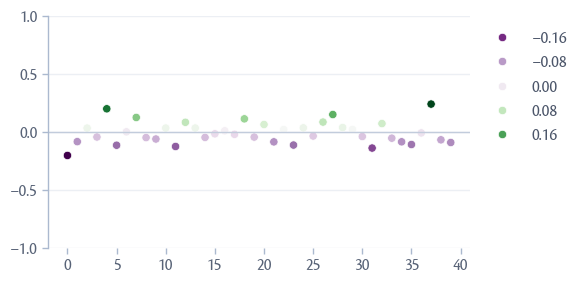

In [6]:
niutils.plot_initial_attitudes(attitudes, number_of_nodes)

Initialize interaction dynamics

In [7]:
A_social = nimodel.initialize_edges(
    G_social=G_social,
    neighbor_weight=init_neighbor_edge_weight,
    non_neighbor_weight=init_non_neighbor_edge_weight
)

## Run simulation
---

In [8]:
# Set up dataframe to track the attitudes over time
attitude_tracker = pl.DataFrame({
    "time": np.repeat(0, repeats=number_of_nodes),
    "node": np.arange(number_of_nodes),
    "attitude": attitudes
})
sim_summary = pl.DataFrame({
    "time": 0,
    "edge_weight_mean": np.mean(A_social),
    "edge_weight_median": np.median(A_social),
    "edge_weight_sd": np.std(A_social),
    "attitude_mean": np.mean(attitudes),
    "attitude_median" : np.median(attitudes),
    "attitude_sd": np.std(attitudes)
})
# Run the simulation
for t in tqdm(range(tmax)):
    A_interaction = nimodel.make_interactions(
        A_social,
        number_of_nodes,
        reciprocate_interactions
    )
    A_social = nimodel.update_edges(
        A_social,
        A_interaction,
        attitudes,
        method="type1"
    )
    attitudes = nimodel.update_attitudes(
        A_social,
        A_interaction,
        attitudes,
        method="type1"
    )
    # Add new rows to track nodes over time
    attitudes_t = pl.DataFrame({
        "time": np.repeat(t, repeats=number_of_nodes),
        "node": np.arange(number_of_nodes),
        "attitude": attitudes
    })
    sim_summary_t = pl.DataFrame({
        "time": t,
        "edge_weight_mean": np.mean(A_social),
        "edge_weight_median": np.median(A_social),
        "edge_weight_sd": np.std(A_social),
        "attitude_mean": np.mean(attitudes),
        "attitude_median" : np.median(attitudes),
        "attitude_sd": np.std(attitudes)
    })
    attitude_tracker = pl.concat([attitude_tracker, attitudes_t])
    sim_summary = pl.concat([sim_summary, sim_summary_t])

100%|██████████| 400/400 [00:02<00:00, 146.50it/s]


## Results
---

Plot all the node attitudes over time.

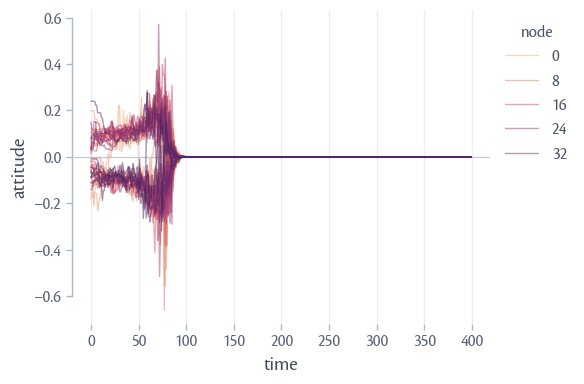

In [9]:
niutils.plot_attitude_evolution(attitude_tracker, tmax)

View the summary table.

In [10]:
sim_summary

time,edge_weight_mean,edge_weight_median,edge_weight_sd,attitude_mean,attitude_median,attitude_sd
i64,f64,f64,f64,f64,f64,f64
0,0.0145,0.01,0.019615,-0.008193,-0.019679,0.092891
0,0.014881,0.01,0.021657,-0.006709,-0.017728,0.091262
1,0.015376,0.01,0.024592,-0.004261,-0.025541,0.093235
2,0.015594,0.01,0.025359,-0.005631,-0.025541,0.095549
3,0.016106,0.01,0.028075,-0.005686,-0.025541,0.099984
4,0.016716,0.01,0.030084,-0.003616,-0.026964,0.095908
5,0.017072,0.01,0.032343,0.000638,-0.026964,0.096752
6,0.017415,0.01,0.032979,-0.003906,-0.045176,0.094475
7,0.017949,0.01,0.035151,-0.01025,-0.044571,0.097705
